In [1]:
# python stdlib
import time
import os
from itertools import product

# Scientific python libraries
import numpy as np
import scipy as sp
import scipy.integrate as spyint
from numba import njit
import sympy as sm
from scipy.constants import e, k, h
from scipy.interpolate import interp1d

# Visualization
import matplotlib.pyplot as plt
import matplotlib.transforms

ROK_ENERGY_UNIT = 1e-3*e
DELTA_UNIT = 1e-3*e
V_RANGE = 0.605
FREQUENCY = 2*np.pi*368*1e6


In [2]:
PARAMETERS = np.loadtxt("parameter.csv", skiprows = 1, delimiter = ',')
print(np.loadtxt("parameter.csv", delimiter = ',',dtype=object)[0,:])

['data set' 'log_g0' 'Gamma_t' 'u' 'alpha' 'temperature' 'log_n']


In [3]:
DATA_SETS = PARAMETERS[:,0]
LN_GAMMA_0 = PARAMETERS[:,1]
GAMMA_T = PARAMETERS[:,2]
GLOBALS_P = PARAMETERS[0,3:]

In [4]:
UDIRS = [float(x[2:]) for x in os.listdir('NRG/') if x[0]=='U']
GAMDIRS = {x:[float(x1[6:]) for x1 in os.listdir(f'NRG/U={x}') if x1[0]=='G'] for x in UDIRS}
GAMDIRS

{0.333: [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07],
 0.416: [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]}

In [5]:
GRAND_DICT = dict()
for UVALS in UDIRS:
    GAMMA_DICT = dict()
    for GAMMA_VALS in GAMDIRS[UVALS]:
        PATHSTR = f'NRG\\U={UVALS}\\Gamma={GAMMA_VALS}\\'
        FILE_NAMES = [x[3:] for x in os.listdir(PATHSTR) if x[0]=='g']
        GAMMA_DICT[GAMMA_VALS] = FILE_NAMES
    GRAND_DICT[UVALS] = GAMMA_DICT

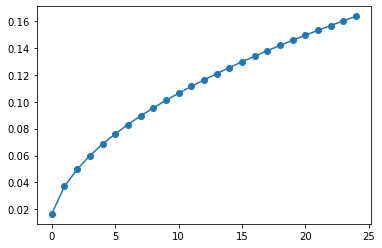

In [21]:
plt.plot(np.float64(GRAND_DICT[0.416][0.03]),'-o')

In [6]:
def nrg_data_func(u, gammat, gap):
    pathstr = f"NRG/U={u}/Gamma={gammat}/gap{gap}/"
    op = np.genfromtxt(pathstr + "optical1.dat")
    n1 = np.genfromtxt(pathstr + "n1.dat")
    n2 = np.genfromtxt(pathstr + "n2.dat")
    return op, n1, n2

In [7]:

def gamma(g0, v0, T, N):
    numerator = np.exp(v0/(k*T)) + N
    denominator = np.exp(v0/(k*T)) - 1
    return g0*numerator/denominator


def etta(g0, v0, T, N):
    numerator = N*gamma(g0, v0, T, N)
    denominator = 4*k*T*((np.cosh(v0/(2*k*T)))**2)
    return numerator/denominator


def llambda(v0, T, N):
    numerator = np.exp(v0/(k*T)) + 1
    denominator = np.exp(v0/(k*T)) + N
    return numerator/denominator


def p0(smg, T, N):
    numerator = np.exp(smg/(k*T))
    denominator = np.exp(smg/(k*T)) + N
    return numerator/denominator


def q_capacitance(smg, T, N, dne, dng):
    return (e**2) * (p0(smg, T, N)*(dne - dng) - dne)


def tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ne - ng)*gamma(g0, smg, T, N)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator


def total_capacitance(g0, smg, dsmg, T, N, ne, ng, dne, dng, w):
    return tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w) + q_capacitance(smg, T, N, dne, dng)


def conductance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ne - ng)*(w**2)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator

In [8]:

def analytical_data(gammat, gap, log_g0, global_parameters, v0):
    u, alpha, temp, log_n = global_parameters
    v0 = v0*alpha
    nu = (1 - v0/u)
    n = 10**log_n
    g0 = 10**log_g0
    
    delta = DELTA_UNIT*np.float64(gap)
    
    if log_g0 == 0.0: g0 = 0.0
    w = FREQUENCY
    
    gamma_t_values = np.array(GAMDIRS[u])
    
    
    gammat_approx = gamma_t_values[np.argmin((gamma_t_values - gammat)**2)]
    
    o1, n1, n2 = nrg_data_func(u,gammat_approx,gap)
    
    s_mg = np.interp(nu, o1[:,0], o1[:, 1])*delta
    n_g  = np.interp(nu, n1[:,0], n1[:, 1])
    n_e  = np.interp(nu, n2[:,0], n2[:, 1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:, 1] - n1[:-1, 1]) / (-0.01*u)) / ROK_ENERGY_UNIT
    dn_e = np.interp(nu, n2[1:,0], (n2[1:, 1] - n2[:-1, 1]) / (-0.01*u)) / ROK_ENERGY_UNIT
    
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    
    ds_mg = np.interp(nu, o1[1:, 0], (o1[1:, 1] - o1[:-1, 1]) / (-0.01*u)) * delta / ROK_ENERGY_UNIT
    
    q_caps = alpha*alpha*q_capacitance(s_mg, temp, n, dn_e, dn_g)*1e15
    t_caps = alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, temp, n, n_e, n_g, w)*1e15
    t_caps = (t_caps + t_caps[::-1])/2
    c_total = q_caps + t_caps
    
    couduc = alpha*alpha*conductance(g0, s_mg, ds_mg, temp, n, n_e, n_g, w)*1e8
    couduc = (couduc + couduc[::-1])/2
    
    return q_caps, c_total, couduc

In [9]:
# nrg_data_func(0.416, 0.01, '0.0165999999999997')
# nrg_data_func(0.416, 0.03, '0.0598521511727022')
# NRG/U=0.416/Gamma=0.01/gap/optical1.dat
# analytical_data(GAMMA_T[0], '0.0165999999999997', LN_GAMMA_0[0], GLOBALS_P, np.array([0]))

In [10]:
# plt.plot(np.float64(GRAND_DICT[0.333][0.01]),
#          [
#              analytical_data(GAMMA_T[0],
#                              GAPVALS,
#                              LN_GAMMA_0[0],
#                              GLOBALS_P,
#                              np.array([-0.1])
#                             )[1]
#              for GAPVALS in GRAND_DICT[0.333][0.01]
#          ]
#         )

In [11]:
def delta_plot(gammat, log_g0, global_parameters, v0, param_idx, save=False):
    
    u, alpha, temp, log_n = global_parameters
    
    gamma_t_values = np.array(GAMDIRS[u])
    gammat_approx = gamma_t_values[np.argmin((gamma_t_values - gammat[param_idx])**2)]
    print('error % = ', np.round(np.abs(gammat_approx - gammat[param_idx])/np.abs(gammat[param_idx]), 2))
    
    matrixx = np.array([
             analytical_data(gammat_approx,
                             gapvals,
                             log_g0[param_idx],
                             global_parameters,
                             v0
                            )[1:]
             for gapvals in GRAND_DICT[0.416][gammat_approx]
         ])
    
    
    y1max = np.max(matrixx[:,0,:])
    y1min = np.min(matrixx[:,0,:])
    y2max = np.max(matrixx[:,1,:])
    y2min = np.min(matrixx[:,1,:])
    s1 = y1max - y1min
    s2 = y2max - y2min
    plt.close('all')
    fig, ax = plt.subplots(1,2,figsize=(15,15))
#     plt.suptitle(f'$\Gamma_t$ = {gammat_approx}')

    parameter_string = f"$T = {temp*1000:.3f} mK $\
      $\\alpha        = {alpha:.3f} $\
      $U       = {u:.3f} meV $\
      $log_{{10}} N   = {log_n:.3f}$\
      $\Gamma_t = {gammat_approx:.3f}$\
      $log \Gamma_0 = {log_g0[param_idx]:.3f}$"
    fig.text(
        0.51, 0.92, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=15)
    
    for idx, rows in enumerate(matrixx):
        xvals = v0
        y1vals = rows[0,:]
        y2vals = rows[1,:]
        ax[0].plot(xvals, idx+(y1vals/s1))
        ax[1].plot(xvals, idx+(y2vals/s2))
    ax[0].set_title('Capacitance, C',fontsize=15)
    ax[0].set_ylim(-1,26)
    ax[0].set_yticks([],[])
    ax2 = ax[0].twinx()
    ax2.set_ylim(-1,26)
    ax2.yaxis.set_ticks_position('right')
    ax2.set_yticks(np.array(list(enumerate(np.round(np.float64(GRAND_DICT[u][gammat_approx]),3))))[::4,0],labels=[], fontsize = 12)
    
    ax[1].set_title('Conductance, G',fontsize=15)
    ax[0].set_ylabel('Gap, $\Delta$ (meV)',fontsize=15)
    ax[0].set_xlabel('$V_{P0} (mV) $',fontsize=17)
    ax[1].set_xlabel('$V_{P0} (mV) $',fontsize=17)
    ax[1].set_yticks(*np.array(list(enumerate(np.round(np.float64(GRAND_DICT[u][gammat_approx]),3))))[::4,:].T, fontsize = 12)
    ax[1].set_ylim(-1,26)
    ax[1].tick_params(axis='x', which='major', labelsize=12)
    ax[0].tick_params(axis='x', which='major', labelsize=12)
    ax[0].text(-0.2,25.2, f'Scale = {s1*1e-15:.2e} F',fontsize=12)
    ax[1].text(-0.2,25.2, f'Scale = {s2*1e-8:.2e} S',fontsize=12)

#     plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45) 

    # Create offset transform by 5 points in x direction
    dx = -0.2; dy = 0.0
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

    # apply offset transform to all x ticklabels.
    for label in ax[1].yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
    if save:
        plt.savefig(f'Delta Dependence idx{param_idx}.pdf',metadata = {'Author': 'R K Rupesh', 'Title': f'Gamma_t 0.03 idx{param_idx}'})
    return fig


fig = delta_plot(GAMMA_T, LN_GAMMA_0, GLOBALS_P, np.arange(-V_RANGE,V_RANGE,0.01), 10, save=True)

In [13]:
EXPERIMENTAL_PATH = "G:/My Drive/GROWTH/Quantum computing/Majorana Project/Experimental data/data-oct4-21-mail-filip/data/"
openbx = np.array([x[18:-4] for x in os.listdir(EXPERIMENTAL_PATH) if x[-1]=='v' and x[11]=='c'])
closebx = np.array([x[16:-4] for x in os.listdir(EXPERIMENTAL_PATH) if x[-1]=='v' and x[11]=='o'])

closebx = np.array(np.sort(np.int32(closebx)), dtype=np.unicode_)
closebx[0] = '00'

openbx = np.array(np.sort(np.int32(openbx)), dtype=np.unicode_)
openbx[0] = '00'


# EXPERIMENTAL_DATA_C = np.array([np.loadtxt(f"{EXPERIMENTAL_PATH}dataset_Bx_closed_{data_set}.csv",
#                                          skiprows = 1,
#                                          delimiter = ',')[:, [0, 1, 5]] for data_set in closebx])
# EXPERIMENTAL_DATA_O = np.array([np.loadtxt(f"{EXPERIMENTAL_PATH}dataset_Bx_open_{data_set}.csv",
#                                          skiprows = 1,
#                                          delimiter = ',')[:, [0, 1, 5]] for data_set in openbx])


def dataset_func_O(Bfield):
    return np.loadtxt(f"{EXPERIMENTAL_PATH}dataset_Bx_open_{Bfield}.csv",
               skiprows = 1,
               delimiter = ',')[:, [0, 1, 5]]

def dataset_func_C(Bfield):
    return np.loadtxt(f"{EXPERIMENTAL_PATH}dataset_Bx_closed_{Bfield}.csv",
               skiprows = 1,
               delimiter = ',')[:, [0, 1, 5]]

In [14]:
V_RANGE = 1.105
# V_RANGE = 0.60

def experimental_data(Bfield,symmetrize): #filter
    exp_v, exp_c, exp_r = dataset_func_C(Bfield).T
    exp_g = 1/exp_r
    exp_v = exp_v*1e3
#     print(np.min(exp_v))
    filter_bool = (exp_v < V_RANGE) * (-V_RANGE < exp_v) #+ True
    
    exp_c = exp_c[filter_bool]*1e15
    exp_g = exp_g[filter_bool]*1e8
    exp_v = exp_v[filter_bool]
    
    if symmetrize:
        exp_c = (exp_c + exp_c[::-1])/2
        exp_g = (exp_g + exp_g[::-1])/2
        
    return exp_v, exp_c, exp_g
matrix_e = np.array([experimental_data(Bfieldvals,0) for Bfieldvals in closebx])
matrix_e.shape

(23, 3, 221)

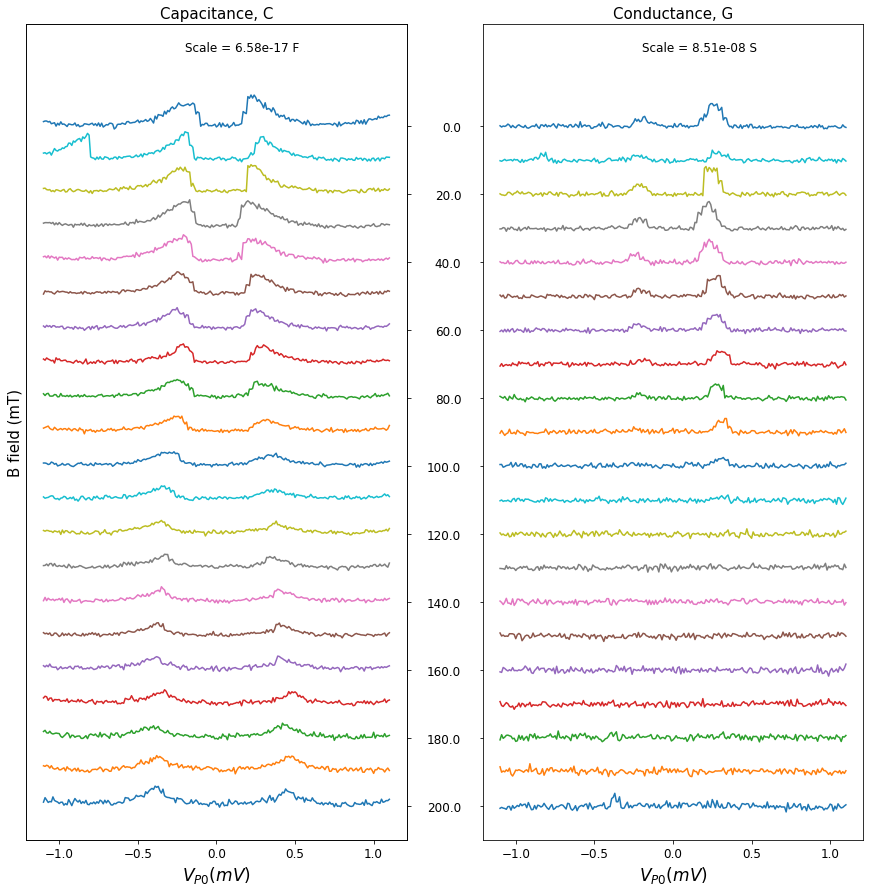

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,15))

y1max = np.max(matrix_e[:-2,1,:])
y1min = np.min(matrix_e[:-2,1,:])
y2max = np.max(matrix_e[:-2,2,:])
y2min = np.min(matrix_e[:-2,2,:])
s1 = (y1max - y1min) #*0 + 1
s2 = (y2max - y2min) #*0 + 1

for idx, rows in enumerate(matrix_e[::-1,:,:]):
    if idx in [0,1]:
        continue
    xvals = rows[0,:]
    y1vals = rows[1,:]
    y2vals = rows[2,:]
    
#     y1max = np.max(rows[1,:])
#     y1min = np.min(rows[1,:])
#     y2max = np.max(rows[2,:])
#     y2min = np.min(rows[2,:])
#     s1 = (y1max - y1min) #*0 + 1
#     s2 = (y2max - y2min) #*0 + 1
    
    ax[0].plot(xvals, idx+(y1vals/s1))
    ax[1].plot(xvals, idx+(y2vals/s2))

ax[1].set_title('Conductance, G',fontsize=15)
ax[0].set_ylabel('B field (mT)',fontsize=15)
ax[0].set_xlabel('$V_{P0} (mV) $',fontsize=17)
ax[1].set_xlabel('$V_{P0} (mV) $',fontsize=17)
ax[0].set_title('Capacitance, C',fontsize=15)

ax[0].set_yticks([],[])
ax2 = ax[0].twinx()
ax2.set_ylim(1,25)
ax[0].set_ylim(1,25)
ax[1].set_ylim(1,25)
ax2.yaxis.set_ticks_position('right')
ax[1].set_yticks(*np.array(list(enumerate(np.float64(closebx[::-1]))))[2::2,:].T, fontsize = 12)
ax2.set_yticks(np.array(list(enumerate(np.float64(closebx[::-1]))))[2::2,0], labels=[], fontsize = 12)

ax[1].tick_params(axis='x', which='major', labelsize=12)
ax[0].tick_params(axis='x', which='major', labelsize=12)
ax[0].text(-0.2,24.2, f'Scale = {s1*1e-15:.2e} F',fontsize=12)
ax[1].text(-0.2,24.2, f'Scale = {s2*1e-8:.2e} S',fontsize=12)

dx = -0.2; dy = 0.0
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax[1].yaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

plt.savefig('Experimental Data Bx Closed_2v0.pdf')

In [16]:
def delta_plot(gammat, log_g0, global_parameters, v0, param_idx, save=False):
    
    u, alpha, temp, log_n = global_parameters
    
    gamma_t_values = np.array(GAMDIRS[u])
    gammat_approx = gamma_t_values[np.argmin((gamma_t_values - gammat[param_idx])**2)]
    print('error % = ', np.round(np.abs(gammat_approx - gammat[param_idx])/np.abs(gammat[param_idx]), 2))
    
    matrix_e = np.array([experimental_data(Bfieldvals,1) for Bfieldvals in closebx])
    matrixx = np.array([
             analytical_data(gammat_approx,
                             gapvals,
                             log_g0[param_idx],
                             global_parameters,
                             v0
                            )[1:]
             for gapvals in GRAND_DICT[0.416][gammat_approx]
         ])
    
    
    y1max = np.max(matrixx[:,0,:])
    y1min = np.min(matrixx[:,0,:])
    y2max = np.max(matrixx[:,1,:])
    y2min = np.min(matrixx[:,1,:])
    s1 = y1max - y1min
    s2 = y2max - y2min
    plt.close('all')
    fig, ax = plt.subplots(1,2,figsize=(15,15))
#     plt.suptitle(f'$\Gamma_t$ = {gammat_approx}')

    parameter_string = f"$T = {temp*1000:.3f} mK $\
      $\\alpha        = {alpha:.3f} $\
      $U       = {u:.3f} meV $\
      $log_{{10}} N   = {log_n:.3f}$\
      $\Gamma_t = {gammat_approx:.3f}$\
      $log \Gamma_0 = {log_g0[param_idx]:.3f}$"
    fig.text(
        0.51, 0.92, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=15)
    
    for idx, rows in enumerate(matrixx):
        xvals = v0
        y1vals = rows[0,:]
        y2vals = rows[1,:]
        ax[0].plot(xvals, idx+(y1vals/s1))
        ax[1].plot(xvals, idx+(y2vals/s2))
    
    y1max = np.max(matrix_e[:,1,:])
    y1min = np.min(matrix_e[:,1,:])
    y2max = np.max(matrix_e[:,2,:])
    y2min = np.min(matrix_e[:,2,:])
    s1 = (y1max - y1min) #*0 + 1
    s2 = (y2max - y2min) #*0 + 1
    for idx, rows in enumerate(matrix_e[::-1,:,:]):
        xvals = rows[0,:]
        y1vals = rows[1,:]
        y2vals = rows[2,:]

#         y1max = np.max(rows[1,:])
#         y1min = np.min(rows[1,:])
#         y2max = np.max(rows[2,:])
#         y2min = np.min(rows[2,:])
#         s1 = (y1max - y1min) #*0 + 1
#         s2 = (y2max - y2min) #*0 + 1

        ax[0].plot(xvals, idx+(y1vals/s1))
        ax[1].plot(xvals, idx+(y2vals/s2))
    
    
    ax[0].set_title('Capacitance, C',fontsize=15)
    ax[0].set_ylim(-1,26)
    ax[0].set_yticks([],[])
    ax2 = ax[0].twinx()
    ax2.set_ylim(-1,26)
    ax2.yaxis.set_ticks_position('right')
    ax2.set_yticks(np.array(list(enumerate(np.round(np.float64(GRAND_DICT[u][gammat_approx]),3))))[::4,0],labels=[], fontsize = 12)
    
    ax[1].set_title('Conductance, G',fontsize=15)
    ax[0].set_ylabel('Gap, $\Delta$ (meV)',fontsize=15)
    ax[0].set_xlabel('$V_{P0} (mV) $',fontsize=17)
    ax[1].set_xlabel('$V_{P0} (mV) $',fontsize=17)
    ax[1].set_yticks(*np.array(list(enumerate(np.round(np.float64(GRAND_DICT[u][gammat_approx]),3))))[::4,:].T, fontsize = 12)
    ax[1].set_ylim(-1,26)
    ax[1].tick_params(axis='x', which='major', labelsize=12)
    ax[0].tick_params(axis='x', which='major', labelsize=12)
    ax[0].text(-0.2,25.2, f'Scale = {s1*1e15:.2e} F',fontsize=12)
    ax[1].text(-0.2,25.2, f'Scale = {s2*1e8:.2e} S',fontsize=12)

#     plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45) 

    # Create offset transform by 5 points in x direction
    dx = -0.2; dy = 0.0
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

    # apply offset transform to all x ticklabels.
    for label in ax[1].yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
    if save:
        plt.savefig(f'Delta Dependence idx{param_idx}.pdf',metadata = {'Author': 'R K Rupesh', 'Title': f'Gamma_t 0.03 idx{param_idx}'})
    return fig


error % =  0.0


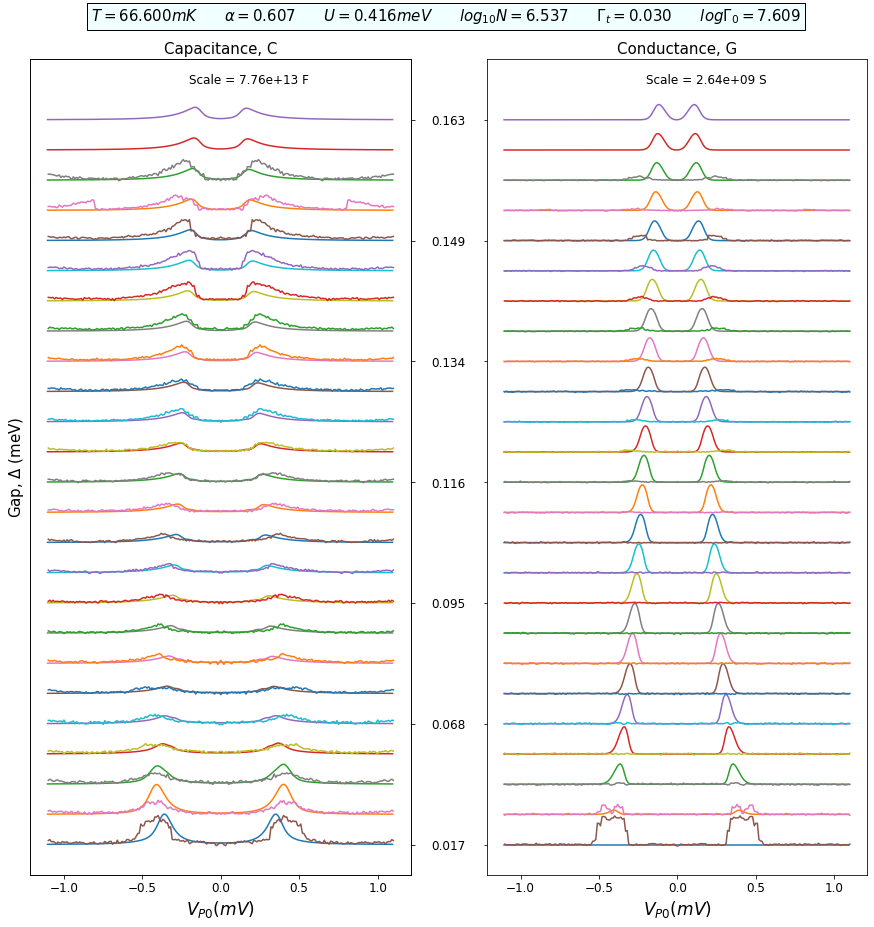

In [17]:
fig = delta_plot(GAMMA_T, LN_GAMMA_0, GLOBALS_P, np.arange(-V_RANGE,V_RANGE,0.01), 5, save=False)